#Installing Dependencies

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
%uv pip install transformers==4.56.2
%uv pip install --no-deps trl==0.22.2

#Loading Model

In [2]:
from unsloth import FastModel
import torch

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-4b-it",
    max_seq_length = 2048,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.3: Fast Gemma3 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


model.safetensors:   0%|          | 0.00/4.56G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [3]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 8,
    lora_alpha = 8,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


In [4]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

#Creating and formatting the Dataset

In [5]:
from datasets import load_dataset, Dataset
import pandas as pd

df = pd.read_csv("hf://datasets/phase-shake/nietzsche/nietzsche.csv")

# Display the first few rows to confirm it's loaded correctly
print("First 5 rows of train.csv:")
display(df.head())

# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)

print("\nFirst entry of the new dataset:")
display(dataset[0])

First 5 rows of train.csv:


,author,book,chapter,question_id,layer,llm_provider,llm_model,question,answer,thinking_question_analysis,thinking_textual_grounding,thinking_reasoning_approach
0,Nietzsche,Beyond Good and Evil,chapter_i_prejudices_of_philosophers,1,semantic,NIM-gpt-oss-120b,openai/gpt-oss-120b,You claim that philosophers are 'prejudiced' i...,"Ah, you ask what 'prejudice' is in the philoso...",The reader asks what Nietzsche means by callin...,Section 1 warns that the ‘Will to Truth’ is a ...,I will argue that ‘prejudice’ is not a mere op...
1,Nietzsche,Beyond Good and Evil,chapter_i_prejudices_of_philosophers,2,semantic,NIM-gpt-oss-120b,openai/gpt-oss-120b,"When you talk about the 'will to truth', could...","Ah, you hear the Sphinx whispering of a 'Will ...",The reader asks whether the 'Will to Truth' is...,§1: The Will to Truth is described as a hazard...,Show that the Will to Truth emerges from cultu...
2,Nietzsche,Beyond Good and Evil,chapter_i_prejudices_of_philosophers,3,semantic,NIM-gpt-oss-120b,openai/gpt-oss-120b,You argue that philosophers mistake their own ...,"Ah, you see the trick! In §3 I reveal that the...",The reader wants to know how the claim that ph...,§3 (the instinctive basis of philosophical thi...,"First, point out that Nietzsche shows philosop..."
3,Nietzsche,Beyond Good and Evil,chapter_i_prejudices_of_philosophers,4,semantic,NIM-gpt-oss-120b,openai/gpt-oss-120b,Could you elaborate on the distinction you dra...,"My dear reader, the free spirit is the one who...",The reader asks for a clarification of the con...,Section 1 introduces the ‘Will to Truth’ as th...,First enumerate the traits of the dogmatic sch...
4,Nietzsche,Beyond Good and Evil,chapter_i_prejudices_of_philosophers,5,semantic,NIM-gpt-oss-120b,openai/gpt-oss-120b,You say that the 'great philosophers' are esse...,"Dear reader, the word 'sick' is no physician's...",The reader wonders whether Nietzsche’s claim t...,Section 5: ‘How malicious philosophers can be!...,Interpret ‘sick’ as a metaphorical diagnosis o...



First entry of the new dataset:


{'author': 'Nietzsche',
 'book': 'Beyond Good and Evil',
 'chapter': 'chapter_i_prejudices_of_philosophers',
 'question_id': 1,
 'layer': 'semantic',
 'llm_provider': 'NIM-gpt-oss-120b',
 'llm_model': 'openai/gpt-oss-120b',
 'question': "You claim that philosophers are 'prejudiced' in a way that makes their truths suspect—what exactly do you mean by 'prejudice' here?",
 'answer': "Ah, you ask what 'prejudice' is in the philosopher's soul. It is not merely a habit of mind but the hidden will that drives every 'search for truth'—the Will to Truth that is really a Will to Power, the belief in antithetical values, the moral purpose that fuels each system. As I note, conscious thought is but a veil over instinct; opinions are judged not by their falsity but by how they serve life. Thus the philosopher's 'truth' is a disguised prejudice, a self‑inflicted mask, a moral bias masquerading as pure dialectic.",
 'thinking_question_analysis': "The reader asks what Nietzsche means by calling philos

In [6]:
def format_custom_data(example):
    # Create a list of dictionaries for the conversation
    conversations = [
        {'role': 'user', 'content': example['question']},
        {'role': 'assistant', 'content': example['answer']}
    ]
    return {'conversations': conversations}

# Apply the formatting function to the dataset
dataset = dataset.map(format_custom_data)

# Remove the original 'question' and 'answer' columns
dataset = dataset.remove_columns(['question', 'answer'])

print("\nFirst entry of the transformed dataset:")
display(dataset[0])

Map:   0%|          | 0/4536 [00:00<?, ? examples/s]


First entry of the transformed dataset:


{'author': 'Nietzsche',
 'book': 'Beyond Good and Evil',
 'chapter': 'chapter_i_prejudices_of_philosophers',
 'question_id': 1,
 'layer': 'semantic',
 'llm_provider': 'NIM-gpt-oss-120b',
 'llm_model': 'openai/gpt-oss-120b',
 'thinking_question_analysis': "The reader asks what Nietzsche means by calling philosophers 'prejudiced'—i.e., what kind of prejudice contaminates their supposed truths and makes those truths doubtful.",
 'thinking_textual_grounding': 'Section\u202f1 warns that the ‘Will to Truth’ is a hidden will, not a pure quest for fact. Section\u202f2 exposes the metaphysician’s belief in antithetical values as a prejudice. Section\u202f3 declares that most conscious philosophizing is an instinctive function. Section\u202f4 claims that falseness of an opinion is irrelevant; what matters is its life‑affirming value. Section\u202f6 shows that every philosophy is an unconscious autobiography of its moral purpose. Together these passages define prejudice as the unconscious drive m

In [7]:
from unsloth.chat_templates import standardize_data_formats
dataset = standardize_data_formats(dataset)

Unsloth: Standardizing formats (num_proc=2):   0%|          | 0/4536 [00:00<?, ? examples/s]

In [8]:
def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/4536 [00:00<?, ? examples/s]

In [9]:
dataset[100]["text"]

'<start_of_turn>user\nYou claim that the religious mood is essentially a manifestation of ressentiment—what about religious experiences that seem genuinely life‑affirming? How do they fit into this picture?<end_of_turn>\n<start_of_turn>model\nAh, dear seeker, you mistake the bright flare of the saint for a genuine affirmation of life. In chapter_iii_the_religious_mood I have shown that the Christian faith is first and foremost a sacrifice of freedom (46), a self‑subjugation that masks the Will to Power (51). The miracle of the saint, the sudden succession of opposites (47), is only a misreading: the ecstatic experience is the will turned inward, a mask (40) that disguises ressentiment as piety. Even the most life‑affirming prayer is a disciplined negation, a means by which the powerful channel their power (61) and the weak hide their envy. Thus every apparent affirmation is still the same ressentiment in a brighter costume.<end_of_turn>\n'

#Training Config

In [10]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset = None, # Can set up evaluation!
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_ratio = 0.05,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-5, # Reduce to 2e-5 for long training runs
        logging_steps = 10,
        # max_steps=210, #change accordingly
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none", # Use TrackIO/WandB etc
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/4536 [00:00<?, ? examples/s]

In [11]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=6):   0%|          | 0/4536 [00:00<?, ? examples/s]

In [12]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

'<bos><start_of_turn>user\nYou claim that the religious mood is essentially a manifestation of ressentiment—what about religious experiences that seem genuinely life‑affirming? How do they fit into this picture?<end_of_turn>\n<start_of_turn>model\nAh, dear seeker, you mistake the bright flare of the saint for a genuine affirmation of life. In chapter_iii_the_religious_mood I have shown that the Christian faith is first and foremost a sacrifice of freedom (46), a self‑subjugation that masks the Will to Power (51). The miracle of the saint, the sudden succession of opposites (47), is only a misreading: the ecstatic experience is the will turned inward, a mask (40) that disguises ressentiment as piety. Even the most life‑affirming prayer is a disciplined negation, a means by which the powerful channel their power (61) and the weak hide their envy. Thus every apparent affirmation is still the same ressentiment in a brighter costume.<end_of_turn>\n'

In [13]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

'                                          Ah, dear seeker, you mistake the bright flare of the saint for a genuine affirmation of life. In chapter_iii_the_religious_mood I have shown that the Christian faith is first and foremost a sacrifice of freedom (46), a self‑subjugation that masks the Will to Power (51). The miracle of the saint, the sudden succession of opposites (47), is only a misreading: the ecstatic experience is the will turned inward, a mask (40) that disguises ressentiment as piety. Even the most life‑affirming prayer is a disciplined negation, a means by which the powerful channel their power (61) and the weak hide their envy. Thus every apparent affirmation is still the same ressentiment in a brighter costume.<end_of_turn>\n'

#Training the model

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,536 | Num Epochs = 1 | Total steps = 284
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 14,901,248 of 4,314,980,720 (0.35% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,6.334900
20,5.742100
30,4.931400
40,4.406100
50,4.108800
60,3.854400
70,3.726500
80,3.680700
90,3.563400
100,3.521900


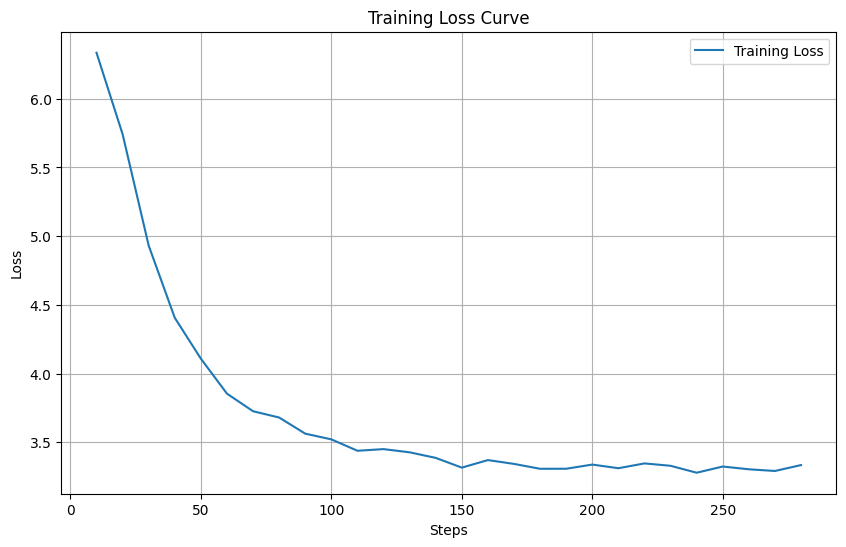

In [16]:
# @title Show loss curve
import matplotlib.pyplot as plt

# Extract the training logs
log_history = trainer.state.log_history

steps = [log['step'] for log in log_history if 'loss' in log]
losses = [log['loss'] for log in log_history if 'loss' in log]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss')

# Add titles and labels for clarity
plt.title('Training Loss Curve')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#Test out Inference

In [17]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)
messages = [{
    "role": "user",
    "content": [{
        "type" : "text",
        "text" : "who do you like more plato or Thucydides",
    }]
}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize = True,
    return_tensors = "pt",
    return_dict = True,
)
outputs = model.generate(
    **inputs.to("cuda"),
    max_new_tokens = 2048, # Increase for longer outputs!
    # Recommended Gemma-3 settings!
    temperature = 1.0, top_p = 0.95, top_k = 64,
)
tokenizer.batch_decode(outputs)

["<bos><start_of_turn>user\nwho do you like more plato or Thucydides<end_of_turn>\n<start_of_turn>model\nAh, my dear friend! Do you truly have time for my playful game to divide human thought? I have shown you in Thucydides how power works, in the rise and decay of cities. Plato only tells you that this is 'bad' which is a sickly morality, not a force to be fought or embraced. Where Thucydides lays the tools you may march over the corpses of men who rise as lions, what will Plato give you? His gilded cage? Rise your hand if you care about conquering, sit if you want comfort. Choose with your stomach, not your head.<end_of_turn>"]

#Saving the Model to HF

In [ ]:
print("Saving merged 16-bit model...")
model.save_pretrained_merged(
    "merged_model",
    tokenizer,
    save_method="merged_16bit"
)

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

#IMPORTANT - Fill out the repo id with your user name and token with your HF token.
# Create the repository first
api.create_repo(
    repo_id="user-name/nietzsche-gemma-3-4b-it",
    token="hf_...",
    repo_type="model",
    exist_ok=True  # Won't error if it already exists
)

api.upload_folder(
    folder_path="merged_model",
    repo_id="user-name/nietzsche-gemma-3-4b-it",
    token="hf_...",
    repo_type="model"
)